This Notebook is for aligning the 4D-STEM tilt series and to do the 6D reconstruction
A cropped reconstruction is expected to be done. Here tomviz was used with sirt 10 iterations in .tif format.

In [1]:
#use this for interactive pop up images
#%matplotlib qt5

In [2]:
import hyperspy.api as hs
import pyxem as pxm
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
import pandas as pd
import time
import gc
import os
from os.path import exists
from scipy.spatial.transform import Rotation
import scipy as sc
from numpy.linalg import norm
import h5py
import dask.array as da
from skimage.transform import resize
import mrcfile
import pyclesperanto_prototype as cle
import scipy.ndimage as ndimage
from ipywidgets import IntProgress
from IPython.display import display
cle.select_device("GTX")

<NVIDIA GeForce GTX 1050 Ti on Platform: NVIDIA CUDA (1 refs)>

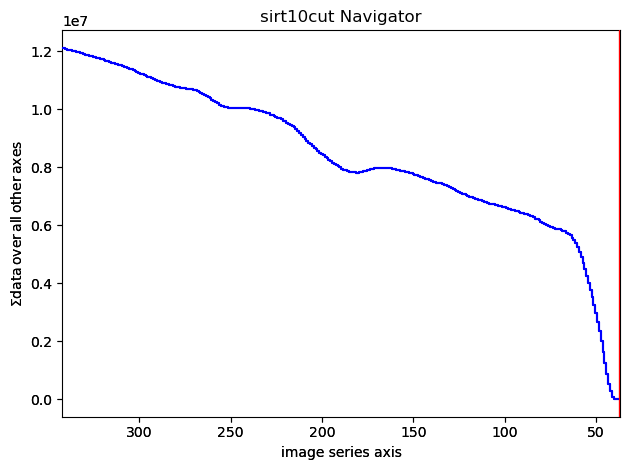

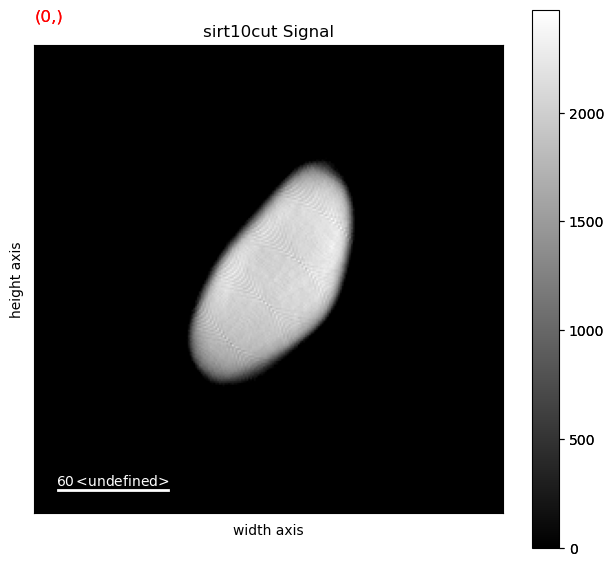

In [9]:
#load the reconstruction
inpath = "D:/data/August2022/TiNi/tomo/"

rec = hs.load(inpath + 'sirt10cut.tif')
rec.set_signal_type('electron_diffraction')
rec.plot(cmap='gray')

In [10]:
#resize the reconstruction to match the 4dstem binning
# At a first step, resize the reconstruction to match the binning used for 4dstem acquisition
bin = 4
recb = resize(rec.data, (rec.data.shape[0] / bin, rec.data.shape[1] / bin, rec.data.shape[2] / bin), anti_aliasing=True)

# on cells below a meanscale value is calculated using Similarity2DTransform. At a second step use this 
#resize the reconstruction to match the meanscale and binning
# meanscale = 0.7163452999020451
# recb = resize(rec.data, ( np.round(meanscale*(rec.data.shape[0] / bin)), np.round(meanscale*(rec.data.shape[1] / bin)), np.round(meanscale*(rec.data.shape[2] / bin))), anti_aliasing=True)

recb = hs.signals.Signal2D(recb)
recb.set_signal_type('electron_diffraction')
#recb.plot(cmap='gray')

del rec
gc.collect()


13989

lets do radon transform from the original resized reconstruction to create the tiltseries we
compare the virtual 4dstem images to get the correct transformation

In [11]:

from skimage.transform import radon

# Get the reprojected tilt series from the reconstruction
# Change the tilt ranges here

Ntilts = 70
starttilt = -64
endtilt = 74
tiltstep = 2

proj= np.zeros((Ntilts,recb.data.shape[0], recb.data.shape[2]))

for ll in range(Ntilts):
    for l in range(recb.data.shape[0]):
        theta = np.linspace(starttilt + ll*tiltstep,1,1) 
        R=radon(recb.data[l,:,:],theta, circle=True)
        proj[ll,recb.data.shape[0]-l-1,:] = np.squeeze(R)

proj1 = hs.signals.Signal2D(proj)
proj1.set_signal_type('electron_diffraction')


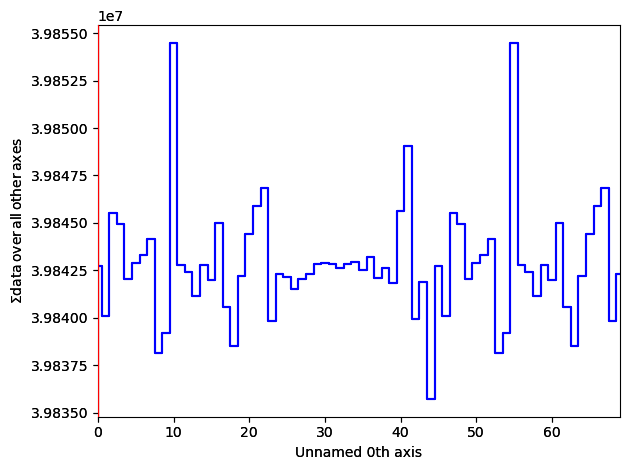

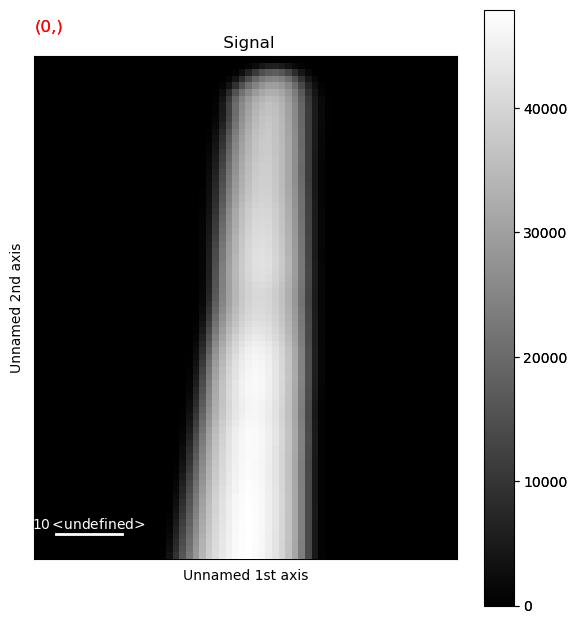

In [12]:
proj1.plot(cmap='gray',norm='auto' )

ITK registration to shift, rotate and scale the virtual detector 4dstem images to the reprojected tiltseries

In [ ]:
from matplotlib.colors import LogNorm
from pylab import figure, cm


# first time use this to get the meanscale variable, then go above, update the meanscale value and reload 
# the original reconstruction and redo all cells also after that
S2DT = sitk.Similarity2DTransform()

#second time use this, no scaling 
#S2DT = sitk.Euler2DTransform()

#Change paths here
#From TomoPeaks.ipynb
outpath2 = 'D:/data/August2022/TiNi/tomo/Tomo_23/post2/'

# I used a mask to cut the lower part of the images away. this made the registration easier...
# if no mask, use dp.data.shape[0]
Cutmask = 40
#Cutmask = dp.data.shape[0]-1




outpathTr = outpath2 + 'transforms/' 
inpath = outpath2
os.makedirs(outpath, exist_ok=True)

roi = hs.roi.CircleROI(cx=0.,cy=0., r=0.1)

test = '4DSTEM_' + str(0)
dp = hs.load(inpath + test +  '.hdf5')
    
R = sitk.ImageRegistrationMethod()


#R.SetMetricAsMeanSquares()
#R.SetMetricAsJointHistogramMutualInformation()
R.SetMetricAsCorrelation()
#R.SetMetricAsMattesMutualInformation(100)
#R.SetMetricSamplingPercentage(0.5)
#R.SetMetricSamplingStrategy(R.RANDOM)

R.SetOptimizerAsRegularStepGradientDescent(1.0, 0.001, 200)
R.SetOptimizerScalesFromIndexShift()
R.SetInterpolator(sitk.sitkLinear)


dp_tilt = np.zeros((Ntilts,dp.data.shape[0],dp.data.shape[1]), dtype=dp.data.dtype)

maskdp = np.ones((dp.data.shape[0],dp.data.shape[1]),dtype=np.ubyte) # mask the bottom part of the images to ease the registration process
maskdp[Cutmask:,:] = 0
maskproj = np.ones((proj1.data.shape[0],proj1.data.shape[1]),dtype=np.ubyte)
maskproj[Cutmask:,:] = 0

R.SetMetricMovingMask(sitk.GetImageFromArray(maskdp))
R.SetMetricFixedMask(sitk.GetImageFromArray(maskproj))
meanscale = 0

for l in range(Ntilts): #Ntilts
    print('l', l)
    tilt0 = proj1.data[l,:,:] 
      
    test = '4DSTEM_' + str(l)
    dp = hs.load(inpath + test +  '.hdf5')

    vdf = dp.get_integrated_intensity(roi)
    vdf = vdf.isig[:,:]*-1
    
    tilt0 = tilt0 - tilt0.min()
    tilt0 = tilt0/tilt0.max()

    vdf   = vdf - vdf.data.min()
    vdf   = vdf/vdf.data.max()
    
    fixed1 = sitk.GetImageFromArray(tilt0)
    moving1= sitk.GetImageFromArray(vdf)

    fixed = sitk.Cast(sitk.RescaleIntensity(fixed1), sitk.sitkFloat32)
    moving = sitk.Cast(sitk.RescaleIntensity(moving1), sitk.sitkFloat32)

    tx = sitk.CenteredTransformInitializer(fixed, moving, S2DT)

    R.SetInitialTransform(tx)
    
    outTx = R.Execute(fixed, moving)
    
    
    test1 = 'transforms_' + str(l)
    sitk.WriteTransform(outTx, outpathTr + test1 + '.tfm') #handling the transforms later on proved to be difficult. Its easier to save them and reload.

    meanscale += outTx.GetParameters()[0]
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(moving)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0.)
    resampler.SetTransform(outTx)

    outr = resampler.Execute(moving) 
    out = sitk.GetArrayFromImage(outr)

    dp_tilt[l,:,:] = out
    del dp
    gc.collect()

meanscale /= Ntilts   
print('meanscale', meanscale) # Use this value for second go

target1 = hs.signals.BaseSignal(dp_tilt)
test = '4DSTEM_dp_tilt_noscale' 
target1.save(inpath + test + '.hdf5', overwrite=True)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 3, 1)
plt.imshow(vdf,cmap='gray',vmin=0.01, vmax=1)
plt.title("1")
fig.add_subplot(1, 3, 2)
plt.imshow(tilt0,cmap='gray',vmin=0.01, vmax=1)
plt.title("2")
fig.add_subplot(1, 3, 3)
plt.imshow(out,cmap='gray') 
plt.title("3")

#meanscale2 0.7163452999020451

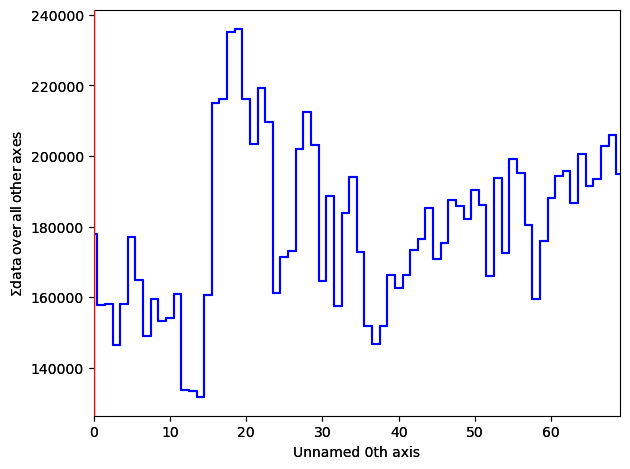

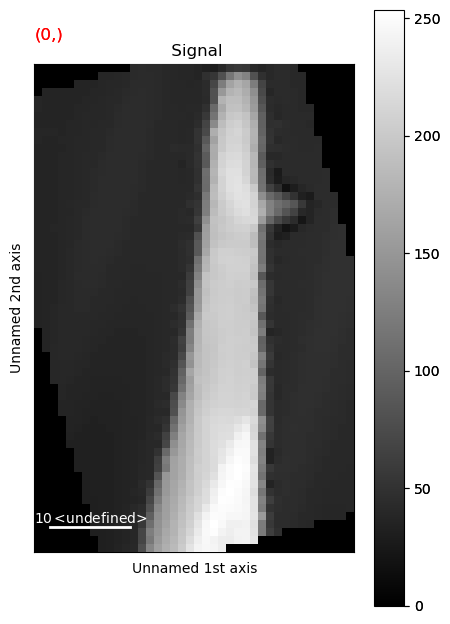

In [14]:
vdfs = hs.load(inpath + test + '.hdf5')
v =vdfs.transpose(navigation_axes=[2])
v.plot(cmap='gray')

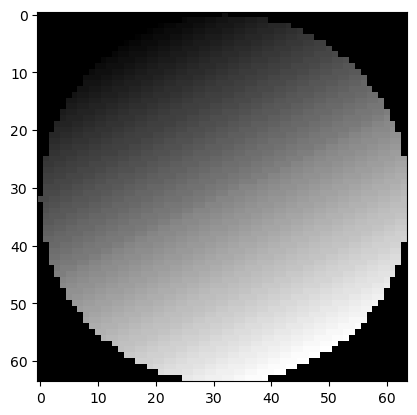

In [18]:
#get nearest neighbour inverse radon index map

from skimage.transform import iradon

angles = np.linspace(starttilt,endtilt,Ntilts, endpoint=True, dtype=float)
dpsize = 256


y = recb.data.shape[1]
x = recb.data.shape[2]
yy = np.linspace(1, y+1, y) # plus one to separate from 0 background
xx = np.linspace(0, 1, 1)
yv, xv = np.meshgrid(yy, xx)

theta=np.linspace(1,2,1)*(starttilt + 0*tiltstep)

Ra=iradon(yv.T,theta, output_size= y,  filter_name=None, interpolation = 'nearest', circle='True',preserve_range='True')#circle='True',
RaStack = np.zeros((Ntilts , Ra.shape[0], Ra.shape[1]))

for i in range(Ntilts):
    theta=np.linspace(1,2,1)*(starttilt + i*tiltstep)
    Ra=iradon(yv.T,theta, output_size= y,  filter_name=None, interpolation = 'nearest', circle='True',preserve_range='True')#circle='True',
    Ra = (Ra - Ra.min())
    Ra = Ra*( (y+1)/Ra.max())
    Ra = Ra.round()
    RaStack[i,:,:] = Ra
    
plt.imshow(RaStack[0,:,:],cmap='gray')

In [ ]:
#Function to calculate the 3D DPs for one plane 

#Change outputh path here
outpath3 = 'D:/data/August2022/TiNi/tomo/Tomo_23/Rec_Planes/'

def write_image_at_angle1( plane, RaStack, angles):

    print('plane',plane)
    
    test = '4DSTEM_dp_tilt_noscale' 
    dp_tilt = hs.load(inpath + test + '.hdf5')
    
    Ra = RaStack[0,:,:]

    f = IntProgress(min=0, max=Ntilts) # instantiate the bar
    display(f) # display the bar

    mask = np.zeros((RaStack.shape[1], RaStack.shape[2]),dtype=bool)
    mask[Ra>0] = True
    
    elapsed = 0
    
    mrcpath = outpath3 + str(plane) + '/'
    os.makedirs(mrcpath, exist_ok=True)
    
    for tilt in range(RaStack.shape[0]):
        
        print('tilt',tilt)
        f.value += 1 # signal to increment the progress bar
        
        test = '4DSTEM2_' + str(tilt)
        dp = hs.load(inpath + test +  '.hdf5')

        test1 = 'transforms_' + str(tilt)
        Tx = sitk.ReadTransform(outpathTr + test1 + '.tfm')
        inv_Tx = Tx.GetInverse()
        
        dp_tilt0 = dp_tilt.data[tilt,:,:]
                 
        Ra = RaStack[tilt,:,:]
        
        for i in range(dp_tilt0.shape[1] - 1,-1,-1): #dp_tilt0[1] # here we go through dp_tilt0 x axis [1] indexes, the y axis is the plane of the rec
         
            t = time.time()
            Ra1 = mask*Ra 

            Ra1[np.where(Ra==(i+1))] = -1 # +1 to match the +1 in the Ra definition
            Ra2 = np.abs(-1*np.where(Ra1>-1, 0, Ra1))
            rasum = Ra2.sum()

            for j in range(int(rasum)): # here we put the dp tilt image into all of the em3d cubes with corresponding tilt angle
                                        # and with corresponding projection rays. one plane only
                ramax = Ra2.argmax()
                ramaxind = np.unravel_index(ramax, (Ra2.shape))
                          
                #transform points from dp_tilt0 back to original dp
                dp_tilt_point = (plane,i)
                dp_point = inv_Tx.TransformPoint(dp_tilt_point)
                
                trans_j = int(np.ceil(dp_point[0]))
                trans_i = int(np.ceil(dp_point[1]))
                
                
                #if dp_tilt0[plane,i] != 0: 
                    #if recb.data[plane,ramaxind[0],ramaxind[1]] != 0: # skip the background              
                if trans_j < dp.data.shape[0]: 
                    if trans_i < dp.data.shape[1]:
              
                        name = 'box_' + '_j_' + str(ramaxind[0]) + '_i_' + str(ramaxind[1]) + '.mrc'

                        if exists(mrcpath + name):
                            if os.path.getsize(mrcpath + name) == 0:
                                os.remove(mrcpath + name) 
                            else:
                                dp3d  = mrcfile.open(mrcpath + name,'r+' )
                        else:
       
                            dp3d  = mrcfile.new(mrcpath + name, np.zeros( ( 
                                        int(dp.data.shape[2] ), int(dp.data.shape[2] ), int(dp.data.shape[2] ) )  , dtype = 'float32'))
                                

                        dpt = dp.data[trans_j,trans_i,:,:]

                        transform = cle.AffineTransform3D()
                        transform.center(dpt.shape)
                        transform.rotate_around_y_axis(angles[tilt])
                        transform.center(dp3d.data.shape, undo=True)

                        temp = cle.create_like(dp3d.data)
                        cle.affine_transform(dpt, temp, transform=transform,linear_interpolation=True)
                        dp3d.set_data(dp3d.data + temp)
  
                        dp3d.close()
                        del temp
                        del dpt
                        gc.collect()
                        
                Ra2[ramaxind] = 0
 

            elapsed = time.time() - t
    
        del Ra
        del dp_tilt0
        del dp
        gc.collect()

In [ ]:
# Calculate all planes
# This calculation took about 1 month for my laptop and about 5.6 Tb data size 

angles = np.linspace(starttilt,endtilt,Ntilts, endpoint=True, dtype=float)

for plane in range(0,recb.data.shape[0]):
    write_image_at_angle1( plane, RaStack, angles)

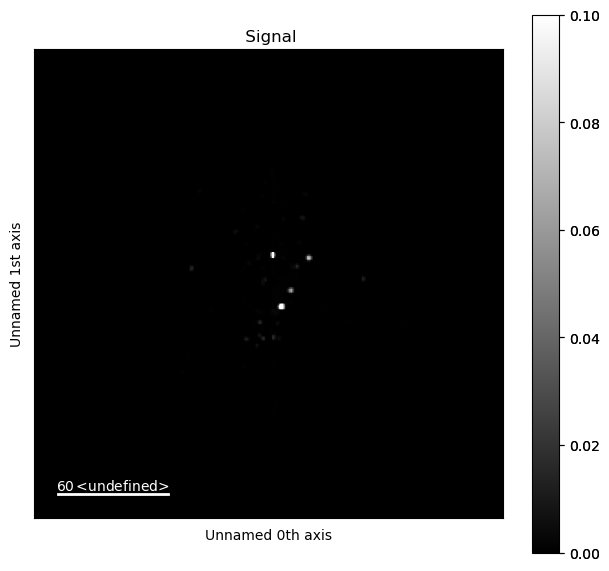

In [46]:
#Visualize one box
# use %matplotlib qt5 to plot interactive

path = outpath3 + str(43) + '/' #plane = 43
name = 'box_' + '_j_' + str(24) + '_i_' + str(24) + '.mrc' # x and y = 24

if exists(path + name):
    dp3d  = mrcfile.open(path + name,'r+' )
else:
    print('nope')
    
s = hs.signals.Signal2D(dp3d.data)                     
s.transpose(signal_axes=(1,2))
#s.plot(cmap='gray',vmin=0,vmax=0.1) # use %matplotlib qt5 to plot interactive
s.inav[125].plot(cmap='gray',vmin=0,vmax=0.1)
dp3d.close()